In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import collections
import logging
import os
import sys
sys.path.append(os.path.abspath("."))
import py_vncorenlp

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
# from vncorenlp import VnCoreNLP
from datasets import Dataset
from scripts.abbreviations import Abb

d:\Anaconda\envs\thktdl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
link_data = 'merged_dataset.csv'
data = pd.read_csv(link_data)
data.head ()

,Id,Label,Comment
0,1,0,"Slayder, GAM cần anh."
1,2,0,"Dạ mỗi khi Gam cần, em luôn sẵn sèng!!"
2,3,0,"sờ ty lè k chỉ nhảy qua tường, sờ ty lè nhảy p..."
3,4,0,Mê cái cách anh này nhảy E
4,5,0,Chúc mừng\nGam đã có kỳ chuyển nhượng thành công


In [ ]:
index = data[data['Label'].isnull() == True].index
data.drop(index, inplace= True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14803 entries, 0 to 14802
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       14803 non-null  int64 
 1   Label    14803 non-null  int64 
 2   Comment  14803 non-null  object
dtypes: int64(2), object(1)
memory usage: 347.1+ KB


In [ ]:
values = set()
data['Label'].apply(lambda x: values.add(x))
print(values)

{0, 1, 2}


In [ ]:
#Đưa các từ lowercase
data['text'] = data['Comment'].str.lower()
#Loại bỏ dấu câu
character = ['\'','.',',','-',':','"','!','~','?',']','*']
character = set(character)
data['text'] = data['text'].apply(lambda x: ''.join([char for char in x if char not in character]))
data.head()

,Id,Label,Comment,text
0,1,0,"Slayder, GAM cần anh.",slayder gam cần anh
1,2,0,"Dạ mỗi khi Gam cần, em luôn sẵn sèng!!",dạ mỗi khi gam cần em luôn sẵn sèng
2,3,0,"sờ ty lè k chỉ nhảy qua tường, sờ ty lè nhảy p...",sờ ty lè k chỉ nhảy qua tường sờ ty lè nhảy ph...
3,4,0,Mê cái cách anh này nhảy E,mê cái cách anh này nhảy e
4,5,0,Chúc mừng\nGam đã có kỳ chuyển nhượng thành công,chúc mừng\ngam đã có kỳ chuyển nhượng thành công


In [ ]:
abb = Abb()
data['text'] = data['text'].apply(lambda x: ''.join([abb.rep(char)+' ' for char in x.split()]))
data.head()

,Id,Label,Comment,text
0,1,0,"Slayder, GAM cần anh.",slayder gam cần anh
1,2,0,"Dạ mỗi khi Gam cần, em luôn sẵn sèng!!",dạ mỗi khi gam cần em luôn sẵn sèng
2,3,0,"sờ ty lè k chỉ nhảy qua tường, sờ ty lè nhảy p...",sờ ty lè không chỉ nhảy qua tường sờ ty lè nhả...
3,4,0,Mê cái cách anh này nhảy E,mê cái cách anh này nhảy em
4,5,0,Chúc mừng\nGam đã có kỳ chuyển nhượng thành công,chúc mừng gam đã có kỳ chuyển nhượng thành công


In [ ]:
path = os.path.join(os.getcwd(), 'scripts')
# py_vncorenlp.download_model(save_dir=path)

In [ ]:
model_vncorenlp = py_vncorenlp.VnCoreNLP(save_dir=path)
data['text'] = data['text'].apply(lambda x: " ".join(word for word in model_vncorenlp.word_segment(x)))

In [ ]:
data_train = []

#Loại bỏ các stopword
path = os.path.join(os.getcwd(), 'vietnamese-stopwords.txt')
if not os.path.exists(path):
    print("Downloading Vietnamese stopwords...")
    url = 'https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt'
    os.system(f"wget {url} -O {path}")
stop_words = set(line.strip() for line in open(path, encoding='utf-8'))
for sentence in data['text']:
    sen_new = ""
    sen_temp = sentence.split()
    #print(sen_temp)
    for word in sen_temp:
        #print(word,'.')
        if (word not in stop_words):
            sen_new += word + " "
        #print()
    data_train.append(sen_new)

print ("Headlines after Preprocessing")
for i in range (0,20):
  print (f"{i+1}/",data_train[i])

Headlines after Preprocessing
1/ slayder gam cần_anh 
2/ gam sẵn sèng 
3/ sờ ty lè không_chỉ nhảy tường sờ ty lè nhảy phát team 
4/ mê nhảy 
5/ chúc_mừng gam kỳ chuyển_nhượng thành_công 
6/ mê nhảy 
7/ chuẩn thoát pressing luônnn 
8/ ok chúc sơn thành công đường tiếp giờ thì hóng ad mới 
9/ gam đầu_tư đi cửa sân_bay 
10/ trận best gánh 
11/ thằng hankay out hài vãi lồn đôn huấn_luyện_viên tạm vị_trí analyst gam tuyển huấn_luyện_viên chả ảnh_hưởng 
12/ msi xong thank you vị_trí sty1e 
13/ đem shogun đem taki 2 đánh kết_hợp 
14/ thầy sty1e lck hướng_dẫn thằng peyz thằng guma đánh zeri 2 thằng đánh ngu 
15/ dũng phạm se gam giúp thoát pressing 
16/ nghi_thức hiến tế bắt_đầu 
17/ ôi cảm_động hoá_thân thành fan gam khứa hơi anti gam một_chút 
18/ kick ác nhường chỗ tướng_quân 
19/ tao đợi thank you kati mãi 
20/ mong sty1e 


In [ ]:
data['Comment'] = data_train

In [ ]:
data = data[data['Comment'].apply(len) > 0]
data.reset_index(inplace = True)
data

,index,Id,Label,Comment,text
0,0,1,0,slayder gam cần_anh,slayder gam cần_anh
1,1,2,0,gam sẵn sèng,dạ mỗi khi gam cần em luôn sẵn sèng
2,2,3,0,sờ ty lè không_chỉ nhảy tường sờ ty lè nhảy ph...,sờ ty lè không_chỉ nhảy qua tường sờ ty lè nhả...
3,3,4,0,mê nhảy,mê cái cách anh này nhảy em
4,4,5,0,chúc_mừng gam kỳ chuyển_nhượng thành_công,chúc_mừng gam đã có kỳ chuyển_nhượng thành_công
...,...,...,...,...,...
14674,14798,10159,0,tâm tailor phạm trúc_giang,tâm tailor phạm trúc_giang
14675,14799,10189,0,hôm_nay thẩm_phán bảo “ chào ca_sĩ đoàn di băn...,hôm_nay mình ra toà thẩm_phán bảo “ chào ca_sĩ...
14676,14800,10191,0,hôm thẩm_phán bảo “ chào ca_sĩ đoàn di băng ”,hôm ra toà thẩm_phán bảo “ chào ca_sĩ đoàn di ...
14677,14801,10193,0,done bom,done em bom


In [ ]:
data.drop(['index'], axis = 1, inplace = True)
data.drop(['text'], axis = 1, inplace = True)
data.drop(['Id'], axis = 1, inplace = True)

In [ ]:
# Flip flag to test on a full dataset
test_flag = False
if test_flag:
    data = data.sample(n = 100, random_state=42).reset_index(drop=True)

In [ ]:
train_df, val_df = train_test_split(data, test_size=0.2, stratify=data['Label'], random_state=42)

In [ ]:
train_df

,Label,Comment
2840,0,gam 1 huấn_luyện_viên nghĩa
13316,0,lệ
8846,0,trọng nguyễn_haiz
10586,2,nguyễn_anh thu đọc xong md quãi
2532,1,tinh_thần hè đừng đi world chuẩn_bị cút
...,...,...
7759,1,nguyễn_trương đan huy lồn
5790,2,đm nhà_đầu_tư đầu buồi no hope chung_kết thế_g...
14203,0,Việt_Nam cũng_nên phát_triển uva bao_gồm tầm c...
8591,0,riel ỏ face


In [ ]:
def format_text(row):
    return {
        "input_text": f"task: classify sentiment comment: {row['Comment']}",
        "target_text": str(row["Label"]) # important: Vit5 requires target_text to be a string
    }

train_data = pd.DataFrame([format_text(row) for _, row in train_df.iterrows()])
val_data = pd.DataFrame([format_text(row) for _, row in val_df.iterrows()])

# Convert to Hugging Face Datasets
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("VietAI/vit5-base")

def tokenize(row):
    model_inputs = tokenizer(
        row["input_text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            row["target_text"],
            truncation=True,
            padding="max_length",
            max_length=10
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = train_dataset.map(tokenize)
val_dataset = val_dataset.map(tokenize)

d:\Anaconda\envs\thktdl\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map:   0%|          | 0/11743 [00:00<?, ? examples/s]d:\Anaconda\envs\thktdl\Lib\site-packages\transformers\tokenization_utils_base.py:3921: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 2936/2936 [00:01<00:00, 2935.25 examples/s]


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("VietAI/vit5-base")

training_args = Seq2SeqTrainingArguments(
    output_dir="./model/vit5-finetuned",
    evaluation_strategy="steps",
    save_strategy="steps",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    num_train_epochs=3,
    save_steps=200,
    eval_steps=200,
    logging_steps=50,
    save_total_limit=2,
    predict_with_generate=True,
    # fp16=True # use only if GPU supports
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

d:\Anaconda\envs\thktdl\Lib\site-packages\torch\cuda\__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
trainer.train()

  2%|▏         | 50/2202 [09:14<6:27:12, 10.80s/it]

{'loss': 2.1324, 'grad_norm': 0.5878552198410034, 'learning_rate': 2.9318801089918257e-05, 'epoch': 0.07}


  5%|▍         | 100/2202 [18:13<6:16:46, 10.75s/it]

{'loss': 0.0732, 'grad_norm': 0.5061157941818237, 'learning_rate': 2.8637602179836513e-05, 'epoch': 0.14}


  7%|▋         | 150/2202 [27:12<6:08:07, 10.76s/it]

{'loss': 0.0631, 'grad_norm': 0.4323504567146301, 'learning_rate': 2.795640326975477e-05, 'epoch': 0.2}


  9%|▉         | 200/2202 [36:10<5:59:13, 10.77s/it]

{'loss': 0.0498, 'grad_norm': 0.46135324239730835, 'learning_rate': 2.7275204359673026e-05, 'epoch': 0.27}


                                                    
  9%|▉         | 200/2202 [46:14<5:59:13, 10.77s/it]

{'eval_loss': 0.04576922580599785, 'eval_runtime': 603.1693, 'eval_samples_per_second': 4.868, 'eval_steps_per_second': 0.305, 'epoch': 0.27}


 11%|█▏        | 250/2202 [55:16<5:50:11, 10.76s/it]   

{'loss': 0.05, 'grad_norm': 0.7662054300308228, 'learning_rate': 2.6594005449591282e-05, 'epoch': 0.34}


 14%|█▎        | 300/2202 [1:04:12<5:40:38, 10.75s/it]

{'loss': 0.0484, 'grad_norm': 0.42837002873420715, 'learning_rate': 2.5912806539509538e-05, 'epoch': 0.41}


 16%|█▌        | 350/2202 [1:13:08<5:30:14, 10.70s/it]

{'loss': 0.0441, 'grad_norm': 1.2104769945144653, 'learning_rate': 2.5231607629427794e-05, 'epoch': 0.48}


 18%|█▊        | 400/2202 [1:22:04<5:21:45, 10.71s/it]

{'loss': 0.0449, 'grad_norm': 0.412100613117218, 'learning_rate': 2.455040871934605e-05, 'epoch': 0.54}


                                                      
 18%|█▊        | 400/2202 [1:32:05<5:21:45, 10.71s/it]

{'eval_loss': 0.04316774010658264, 'eval_runtime': 600.967, 'eval_samples_per_second': 4.885, 'eval_steps_per_second': 0.306, 'epoch': 0.54}


 20%|██        | 450/2202 [1:41:04<5:14:23, 10.77s/it]  

{'loss': 0.0441, 'grad_norm': 0.43300268054008484, 'learning_rate': 2.3869209809264304e-05, 'epoch': 0.61}


 23%|██▎       | 500/2202 [1:50:00<5:04:06, 10.72s/it]

{'loss': 0.0392, 'grad_norm': 0.5960659980773926, 'learning_rate': 2.318801089918256e-05, 'epoch': 0.68}


 25%|██▍       | 550/2202 [1:58:58<4:55:42, 10.74s/it]

{'loss': 0.0465, 'grad_norm': 0.2774997353553772, 'learning_rate': 2.2506811989100816e-05, 'epoch': 0.75}


 27%|██▋       | 600/2202 [2:07:55<4:47:26, 10.77s/it]

{'loss': 0.0376, 'grad_norm': 0.36112040281295776, 'learning_rate': 2.1825613079019072e-05, 'epoch': 0.82}


                                                      
 27%|██▋       | 600/2202 [2:17:55<4:47:26, 10.77s/it]

{'eval_loss': 0.03553576022386551, 'eval_runtime': 600.0559, 'eval_samples_per_second': 4.893, 'eval_steps_per_second': 0.307, 'epoch': 0.82}


 30%|██▉       | 650/2202 [2:26:54<4:37:24, 10.72s/it]  

{'loss': 0.0415, 'grad_norm': 0.567253589630127, 'learning_rate': 2.114441416893733e-05, 'epoch': 0.89}


 32%|███▏      | 700/2202 [2:35:50<4:28:29, 10.73s/it]

{'loss': 0.0411, 'grad_norm': 0.4027552604675293, 'learning_rate': 2.0463215258855585e-05, 'epoch': 0.95}


 34%|███▍      | 750/2202 [2:44:46<4:20:00, 10.74s/it]

{'loss': 0.0365, 'grad_norm': 0.12806706130504608, 'learning_rate': 1.978201634877384e-05, 'epoch': 1.02}


 36%|███▋      | 800/2202 [2:53:43<4:12:31, 10.81s/it]

{'loss': 0.0353, 'grad_norm': 0.6185845136642456, 'learning_rate': 1.9100817438692097e-05, 'epoch': 1.09}


                                                      
 36%|███▋      | 800/2202 [3:04:01<4:12:31, 10.81s/it]

{'eval_loss': 0.035862378776073456, 'eval_runtime': 617.4898, 'eval_samples_per_second': 4.755, 'eval_steps_per_second': 0.298, 'epoch': 1.09}


 39%|███▊      | 850/2202 [3:12:59<4:01:35, 10.72s/it]  

{'loss': 0.0363, 'grad_norm': 0.6992283463478088, 'learning_rate': 1.8419618528610353e-05, 'epoch': 1.16}


 41%|████      | 900/2202 [3:21:56<3:52:49, 10.73s/it]

{'loss': 0.0342, 'grad_norm': 0.8926287293434143, 'learning_rate': 1.773841961852861e-05, 'epoch': 1.23}


 43%|████▎     | 950/2202 [3:30:53<3:42:16, 10.65s/it]

{'loss': 0.0308, 'grad_norm': 1.2230488061904907, 'learning_rate': 1.7057220708446866e-05, 'epoch': 1.29}


 45%|████▌     | 1000/2202 [3:39:47<3:33:51, 10.68s/it]

{'loss': 0.0318, 'grad_norm': 1.2269766330718994, 'learning_rate': 1.6376021798365122e-05, 'epoch': 1.36}


                                                       
 45%|████▌     | 1000/2202 [3:49:46<3:33:51, 10.68s/it]

{'eval_loss': 0.03508400544524193, 'eval_runtime': 598.7448, 'eval_samples_per_second': 4.904, 'eval_steps_per_second': 0.307, 'epoch': 1.36}


 48%|████▊     | 1050/2202 [3:58:45<3:24:41, 10.66s/it]  

{'loss': 0.0314, 'grad_norm': 0.5376136898994446, 'learning_rate': 1.569482288828338e-05, 'epoch': 1.43}


 50%|████▉     | 1100/2202 [4:07:40<3:17:16, 10.74s/it]

{'loss': 0.0367, 'grad_norm': 0.5480591058731079, 'learning_rate': 1.5013623978201635e-05, 'epoch': 1.5}


 52%|█████▏    | 1150/2202 [4:16:36<3:07:27, 10.69s/it]

{'loss': 0.0326, 'grad_norm': 0.7290330529212952, 'learning_rate': 1.433242506811989e-05, 'epoch': 1.57}


 54%|█████▍    | 1200/2202 [4:25:32<2:58:41, 10.70s/it]

{'loss': 0.0255, 'grad_norm': 0.580331563949585, 'learning_rate': 1.3651226158038147e-05, 'epoch': 1.63}


                                                       
 54%|█████▍    | 1200/2202 [4:35:32<2:58:41, 10.70s/it]

{'eval_loss': 0.034734178334474564, 'eval_runtime': 600.1771, 'eval_samples_per_second': 4.892, 'eval_steps_per_second': 0.307, 'epoch': 1.63}


 57%|█████▋    | 1250/2202 [4:44:32<2:50:48, 10.77s/it]  

{'loss': 0.0309, 'grad_norm': 0.30981698632240295, 'learning_rate': 1.2970027247956403e-05, 'epoch': 1.7}


 59%|█████▉    | 1300/2202 [4:53:29<2:41:42, 10.76s/it]

{'loss': 0.0277, 'grad_norm': 0.8153719902038574, 'learning_rate': 1.228882833787466e-05, 'epoch': 1.77}


 61%|██████▏   | 1350/2202 [5:02:25<2:31:52, 10.70s/it]

{'loss': 0.0353, 'grad_norm': 0.994773268699646, 'learning_rate': 1.1607629427792916e-05, 'epoch': 1.84}


 64%|██████▎   | 1400/2202 [5:11:21<2:22:38, 10.67s/it]

{'loss': 0.0338, 'grad_norm': 0.9618178009986877, 'learning_rate': 1.0926430517711172e-05, 'epoch': 1.91}


                                                       
 64%|██████▎   | 1400/2202 [5:21:22<2:22:38, 10.67s/it]

{'eval_loss': 0.03394591435790062, 'eval_runtime': 600.4149, 'eval_samples_per_second': 4.89, 'eval_steps_per_second': 0.306, 'epoch': 1.91}


 66%|██████▌   | 1450/2202 [5:30:21<2:13:44, 10.67s/it]  

{'loss': 0.028, 'grad_norm': 0.9289987087249756, 'learning_rate': 1.0245231607629428e-05, 'epoch': 1.98}


 68%|██████▊   | 1500/2202 [5:39:17<2:07:10, 10.87s/it]

{'loss': 0.0265, 'grad_norm': 0.39575114846229553, 'learning_rate': 9.564032697547684e-06, 'epoch': 2.04}


 70%|███████   | 1550/2202 [5:48:14<1:56:37, 10.73s/it]

{'loss': 0.0234, 'grad_norm': 0.9096792340278625, 'learning_rate': 8.88283378746594e-06, 'epoch': 2.11}


 73%|███████▎  | 1600/2202 [5:57:16<1:50:51, 11.05s/it]

{'loss': 0.0236, 'grad_norm': 0.8568198680877686, 'learning_rate': 8.201634877384195e-06, 'epoch': 2.18}


                                                       
 73%|███████▎  | 1600/2202 [6:07:19<1:50:51, 11.05s/it]

{'eval_loss': 0.034980472177267075, 'eval_runtime': 603.0884, 'eval_samples_per_second': 4.868, 'eval_steps_per_second': 0.305, 'epoch': 2.18}


 75%|███████▍  | 1650/2202 [6:16:17<1:38:24, 10.70s/it]  

{'loss': 0.0226, 'grad_norm': 1.0808173418045044, 'learning_rate': 7.520435967302452e-06, 'epoch': 2.25}


 77%|███████▋  | 1700/2202 [6:25:14<1:29:28, 10.69s/it]

{'loss': 0.0245, 'grad_norm': 0.463199645280838, 'learning_rate': 6.8392370572207086e-06, 'epoch': 2.32}


 79%|███████▉  | 1750/2202 [6:34:10<1:20:39, 10.71s/it]

{'loss': 0.0236, 'grad_norm': 0.3972378969192505, 'learning_rate': 6.158038147138965e-06, 'epoch': 2.38}


 82%|████████▏ | 1800/2202 [6:43:08<1:11:57, 10.74s/it]

{'loss': 0.0198, 'grad_norm': 0.1864795684814453, 'learning_rate': 5.476839237057221e-06, 'epoch': 2.45}


                                                       
 82%|████████▏ | 1800/2202 [6:53:11<1:11:57, 10.74s/it]

{'eval_loss': 0.041107602417469025, 'eval_runtime': 603.1118, 'eval_samples_per_second': 4.868, 'eval_steps_per_second': 0.305, 'epoch': 2.45}


 84%|████████▍ | 1850/2202 [7:02:11<1:02:55, 10.73s/it]  

{'loss': 0.0259, 'grad_norm': 0.22753553092479706, 'learning_rate': 4.795640326975477e-06, 'epoch': 2.52}


 86%|████████▋ | 1900/2202 [7:11:07<53:45, 10.68s/it]  

{'loss': 0.0234, 'grad_norm': 0.2967721223831177, 'learning_rate': 4.114441416893733e-06, 'epoch': 2.59}


 89%|████████▊ | 1950/2202 [7:20:08<45:22, 10.80s/it]

{'loss': 0.0215, 'grad_norm': 1.1047695875167847, 'learning_rate': 3.433242506811989e-06, 'epoch': 2.66}


 91%|█████████ | 2000/2202 [7:29:06<36:27, 10.83s/it]

{'loss': 0.0216, 'grad_norm': 0.3404567837715149, 'learning_rate': 2.752043596730245e-06, 'epoch': 2.72}


                                                     
 91%|█████████ | 2000/2202 [7:39:09<36:27, 10.83s/it]

{'eval_loss': 0.03743241727352142, 'eval_runtime': 602.6404, 'eval_samples_per_second': 4.872, 'eval_steps_per_second': 0.305, 'epoch': 2.72}


 93%|█████████▎| 2050/2202 [7:48:07<27:08, 10.71s/it]    

{'loss': 0.0219, 'grad_norm': 0.7458354830741882, 'learning_rate': 2.070844686648502e-06, 'epoch': 2.79}


 95%|█████████▌| 2100/2202 [7:57:01<17:59, 10.58s/it]

{'loss': 0.0233, 'grad_norm': 1.389621615409851, 'learning_rate': 1.3896457765667574e-06, 'epoch': 2.86}


 98%|█████████▊| 2150/2202 [8:05:56<09:15, 10.68s/it]

{'loss': 0.0213, 'grad_norm': 0.6549739241600037, 'learning_rate': 7.084468664850136e-07, 'epoch': 2.93}


100%|█████████▉| 2200/2202 [8:14:58<00:23, 11.60s/it]

{'loss': 0.0173, 'grad_norm': 0.47928938269615173, 'learning_rate': 2.7247956403269755e-08, 'epoch': 3.0}


                                                     
100%|█████████▉| 2200/2202 [8:25:02<00:23, 11.60s/it]

{'eval_loss': 0.03717748448252678, 'eval_runtime': 603.3618, 'eval_samples_per_second': 4.866, 'eval_steps_per_second': 0.305, 'epoch': 3.0}


100%|██████████| 2202/2202 [8:25:27<00:00, 13.77s/it] 

{'train_runtime': 30327.0503, 'train_samples_per_second': 1.162, 'train_steps_per_second': 0.073, 'train_loss': 0.08137288209487371, 'epoch': 3.0}


TrainOutput(global_step=2202, training_loss=0.08137288209487371, metrics={'train_runtime': 30327.0503, 'train_samples_per_second': 1.162, 'train_steps_per_second': 0.073, 'total_flos': 5363244381634560.0, 'train_loss': 0.08137288209487371, 'epoch': 3.0})

In [ ]:
trainer.save_model("./model/vit5-finetuned")
tokenizer.save_pretrained("./model/vit5-finetuned")

('./model/vit5-finetuned\\tokenizer_config.json',
 './model/vit5-finetuned\\special_tokens_map.json',
 './model/vit5-finetuned\\tokenizer.json')

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model_path = "./model/vit5-finetuned"
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir=model_path,
    per_device_eval_batch_size=16,
    predict_with_generate=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer
)

true_labels = val_data["target_text"].tolist()
predictions = trainer.predict(val_dataset)

decoded_preds = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)

decoded_preds = [pred.strip().lower() for pred in decoded_preds]
true_labels = [label.strip().lower() for label in true_labels]

acc = accuracy_score(true_labels, decoded_preds)
precision = precision_score(true_labels, decoded_preds, average="macro", zero_division=0)
recall = recall_score(true_labels, decoded_preds, average="macro", zero_division=0)
f1 = f1_score(true_labels, decoded_preds, average="macro")

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


d:\Anaconda\envs\thktdl\Lib\site-packages\transformers\generation\utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 184/184 [18:54<00:00,  6.17s/it]

Accuracy:  0.8815
Precision: 0.7696
Recall:    0.7734
F1 Score:  0.7715


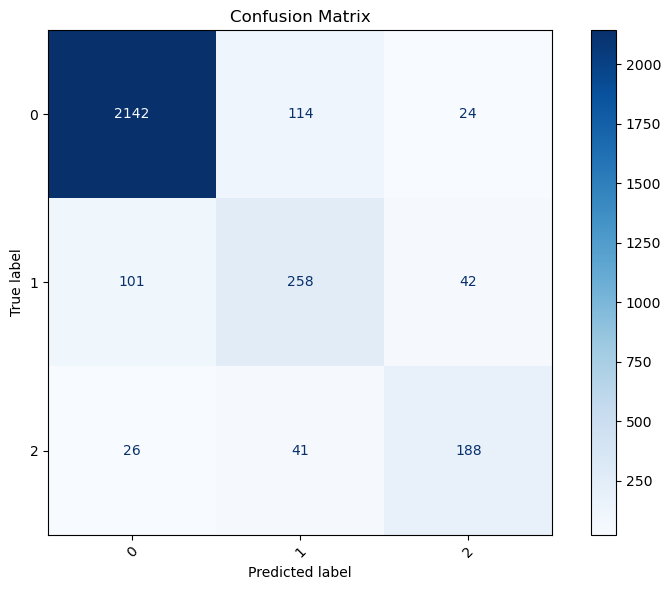

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, decoded_preds, labels=list(set(true_labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(true_labels)))

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
input_sentences = val_data["input_text"].tolist()
cleaned_sentences = [
    sentence.replace("task: classify sentiment comment:", "").strip()
    for sentence in input_sentences
]

sentence_difference = []
predict_label = []
true_label = []

for i in range(len(true_labels)):
    if decoded_preds[i] != true_labels[i]:
        sentence_difference.append(cleaned_sentences[i])
        predict_label.append(decoded_preds[i])
        true_label.append(true_labels[i])

df_differ = pd.DataFrame({
    "Sentence": sentence_difference,
    "Predict": predict_label,
    "True": true_label
})

pd.set_option("display.max_rows", None)  # In tất cả các hàng
print(df_differ)

                                              Sentence Predict True
0    levi pick kindred đi rừng bù vai_trò xạ_thủ đi...       1    0
1       rác thu_gom đi chôn lấp xử_lý 1 biến vĩnh_viễn       0    1
2                der trải xong bọn rác vãi lồn se thầy       2    1
3    kati style đánh thế_thì chịukati tâm_lý thằng ...       1    0
4    chia_tay viết post đọc chối lồn thực_sự đỉnh_c...       1    2
5                                    đóng tiền phim sx       0    1
6                             lê_khánh linh it vãi lồn       1    0
7                                      lồn nè top 6msi       1    2
8    giờ_ren slayder gam ngon đi chung_kết thế_giới...       1    0
9    30% cổ_đông chiếm 1/3 cổ_phần con_mẹ zị ql bắt...       1    0
10                                             ngứa di       0    1
11         tập như_điên mà_còn nổi đòi uống mỡ lolllll       2    0
12                     bán_độ ntn ổn bao_giờ tiêu tiền       0    1
13                                      hài vãi 

In [ ]:
def predict_comment_vit5(text, model, tokenizer, max_len=128, device='cpu'):
    import re
    import torch

    model.to(device)
    model.eval()

    text = text.lower()
    text = re.sub(r"[\[\]\(\)\{\}]", " ", text)
    text = re.sub(r"[\'\.\,\-\:\"!~\?\*\']", "", text)
    text = re.sub(r'\s+', ' ', text).strip()

    inputs = tokenizer(
        text,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=10,
            num_beams=4,
            early_stopping=True
        )

    preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    predicted_label = preds[0].strip().lower()

    return predicted_label


In [ ]:
text = "vãi cặc ha ha ha"
predicted_label = predict_comment_vit5(text, model, tokenizer, device='cuda' if torch.cuda.is_available() else 'cpu')

print("Label dự đoán:", predicted_label)

Label dự đoán: 0
